## Dataset loading using braindecode

In [4]:
import braindecode

In [5]:
import torch
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset

In [6]:
raw_dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=None)

Preprocess dataset using braindecode API

In [7]:
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

In [8]:
# low_freq = 4
# high_freq = 38
# resample_freq = 250

# # preprocess data using "braindecode.preprocessor"
# # only use eeg(stim channels must be removed)
# preprocessors = [Preprocessor('pick', picks=['eeg'])]

# # if pick_channels:
# #     preprocessors.append(Preprocessor('pick', picks=pick_channels))
# # preprocessors.append(Preprocessor(lambda data: multiply(data, 1e6)))


# # if low_freq or high_freq:
#     # preprocessors.append(Preprocessor('filter', l_freq=low_freq, h_freq=high_freq))
# if resample_freq:
#     preprocessors.append(Preprocessor('resample', sfreq=resample_freq))
# preprocessors.append(Preprocessor(exponential_moving_standardize, factor_new=1e-3))
# preprocess(raw_dataset, preprocessors)

# from braindecode.preprocessing import MNEPreproc, NumpyPreproc, preprocess

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    Preprocessor(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    Preprocessor(fn=lambda x: x * 1e6),
    # bandpass filter
    Preprocessor(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    Preprocessor(fn=exponential_moving_standardize, factor_new=factor_new,
        init_block_size=init_block_size)
]

# Preprocess the data
preprocess(raw_dataset, preprocessors)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Window Split (for each trail start and end)

In [9]:
start_offset = -0.5
stop_offset = 0

sfreq = raw_dataset.datasets[0].raw.info['sfreq']
#assert all([ds.raw.info['sfreq'] == sfreq for ds in raw_dataset.datasets])
trial_start_offset_samples = int(start_offset * sfreq)
trial_stop_offset_samples = int(stop_offset * sfreq)

windows_dataset = create_windows_from_events(
    raw_dataset,
    trial_start_offset_samples,
    trial_stop_offset_samples,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [10]:
import pandas as pd
meta = pd.DataFrame(windows_dataset.get_metadata())
meta.to_csv('windows_dataset.csv')
meta

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,125,1250,3,1,0train,0
1,0,2128,3253,0,1,0train,0
2,0,4046,5171,2,1,0train,0
3,0,5998,7123,1,1,0train,0
4,0,8006,9131,1,1,0train,0
...,...,...,...,...,...,...,...
43,0,86625,87750,0,9,1test,5
44,0,88531,89656,3,9,1test,5
45,0,90459,91584,0,9,1test,5
46,0,92573,93698,1,9,1test,5


In [11]:
sess_list = meta['session'].tolist()

In [12]:
import numpy as np

In [13]:
np.unique(meta['session'], return_counts = True)

(array(['0train', '1test'], dtype=object), array([2592, 2592], dtype=int64))

Get additional dataset details and set model configuration

In [14]:
n_channels = raw_dataset[0][0].shape[0]
n_times = windows_dataset[0][0].shape[1]
n_classes = 4 # number of classes in the dataset used

n_epochs = 100
lr = 0.001
batch_size = 64

# variables to save the model
save = 'store_true'
save_dir = 'models/'
strategy = 'within-subject' # 'within-subject' or 'cross-subject'
model_name = 'EEGNet' # 'EEGNet', 'EEGConformer', 'ATCNet', 'EEGITNet', 'EEGInception'
verbose = 2

Split data  into test and train based on window subset

In [15]:
from skorch.helper import SliceDataset
from skorch.callbacks import LRScheduler, TrainEndCheckpoint
from skorch import NeuralNetClassifier

cuda = torch.cuda.is_available()


In [16]:
str(sess_list[0])

'0train'

In [17]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(windows_dataset)):
    x, target, window_ind = windows_dataset[i]
    # print(f"Shape of window {i}: {x.shape}, Label: {target}")
    if sess_list[i]=='0train':
        X_train.append(x)
        y_train.append(target)
    else:
        if i<3456:
            X_train.append(x)
            y_train.append(target)
        else:
            X_test.append(x)
            y_test.append(target)

In [18]:
# X = []
# y = []
# for i in range(len(windows_dataset)):
#     x, target, window_ind = windows_dataset[i]
#     # print(f"Shape of window {i}: {x.shape}, Label: {target}")
#     X.append(x)
#     y.append(target)

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [20]:
X_train = np.array(X_train)
X_test = np.array(X_test)
enc = OneHotEncoder()
y_train = enc.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = enc.transform(np.array(y_test).reshape(-1,1)).toarray()

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [22]:
print("Train class split:")
unique_elements, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
for value, count in zip(unique_elements, counts):
    print(f"{value}: {count}")
print("Test class split:")
unique_elements, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
for value, count in zip(unique_elements, counts):
    print(f"{value}: {count}")

Train class split:
0: 1080
1: 1080
2: 1080
3: 1080
Test class split:
0: 216
1: 216
2: 216
3: 216


In [23]:
X_train.shape

(4320, 22, 1125)

In [24]:
y_train.shape

(4320, 4)

In [25]:
np.unique(np.argmax(y_test, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([216, 216, 216, 216], dtype=int64))

In [26]:
np.unique(np.argmax(y_train, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([1080, 1080, 1080, 1080], dtype=int64))

In [27]:
from sklearn.metrics import *

In [28]:
def test_metrics(model, X_test = X_test):
    pred = model.predict(X_test)
    # print(np.argmax(y_test, axis=1)[0])
    # print(pred[0])
    print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), pred))
    print("Precision: ", precision_score(np.argmax(y_test, axis=1), pred, average='weighted'))
    print("Recall: ", recall_score(np.argmax(y_test, axis=1), pred, average='weighted'))
    print("F1: ", f1_score(np.argmax(y_test, axis=1), pred, average='weighted'))

In [29]:
def test_metrics_onehot(model, X_test = X_test):
    pred = model.predict(X_test)
    i=0
    for a in pred:
        temp = [0, 0, 0, 0] 
        temp[np.argmax(a)] = 1
        pred[i] = temp
        i+=1
    # print(y_test[0])
    # print(pred[0])
    print("Accuracy: ", accuracy_score(y_test, pred))
    print("Precision: ", precision_score(y_test, pred, average='weighted'))
    print("Recall: ", recall_score(y_test, pred, average='weighted'))
    print("F1: ", f1_score(y_test, pred, average='weighted'))

In [30]:
import numpy as np
import os
import mne
from scipy.io import loadmat

def add_awgn_noise(signal, snr):
    """
    Add AWGN noise to the signal based on a desired SNR.
    Args:
        signal (numpy.array): Original EEG signals.
        snr (float): Desired signal-to-noise ratio in dB.
    Returns:
        numpy.array: Signal with added Gaussian noise.
    """
    sig_power = np.mean(np.power(signal, 2))
    sig_db = 10 * np.log10(sig_power)
    noise_db = sig_db - snr
    noise_power = np.power(10, noise_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    noisy_signal = signal + noise
    return noisy_signal
def create_noisy_dataset(data, snr):
    """
    Apply AWGN to each sample in the dataset.
    Args:
        data (numpy.array): Original EEG dataset.
        snr (float): Desired signal-to-noise ratio.
    Returns:
        numpy.array: Noisy EEG dataset.
    """
    noisy_data = np.array([add_awgn_noise(sample, snr) for sample in data])
    return noisy_data

from numpy import dot
from numpy.linalg import norm

def cosine_similarity(arr1, arr2):
    return dot(arr1.flatten(), arr2.flatten()) / (norm(arr1) * norm(arr2))


In [31]:
X_test_noise = create_noisy_dataset(X_test, snr = 8)
similarity = cosine_similarity(X_test_noise, X_test)
print("Similarity with original data: ",similarity)

Similarity with original data:  0.9292072554756868


In [32]:
X_test_noise_2 = create_noisy_dataset(X_test, snr = 12)
similarity = cosine_similarity(X_test_noise_2, X_test)
print("Similarity with original data: ",similarity)

Similarity with original data:  0.9700179191880101


In [33]:
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

In [34]:
cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 16)

In [35]:
def CV_train(model, X, X_test, cnn = False, convlstm = False, batch_size = 32, n_epochs = 50, y_out = y_train, y_out_test = y_test):
    acc = []
    f1 = []
    prec = []
    recall = []
    results = {}
    best_model = model
    prev_metric = 0
    best_hist = []
    for train_idx, val_idx in cv.split(y_out):

        nn = [] 

        label_train, _ = y_out[train_idx], y_out[val_idx]
        y_train, y_val = y_out[train_idx], y_out[val_idx] 

        X_train = X[train_idx] 
        X_val = X[val_idx] 
        
        if cnn:
            X_train = np.expand_dims(X_train,-1)
        elif convlstm:
            X_train = np.expand_dims(np.expand_dims(X_train, -1),-1)

        nn = model

        history = nn.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = batch_size, epochs = n_epochs)

        y_pred = nn.predict(X_val)
        pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

        acc_score = accuracy_score(y_val.argmax(axis=1), pred.argmax(axis=1))
        acc.append(acc_score)
        f1_val = (f1_score(y_val.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
        f1.append(f1_val)
        prec.append(precision_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        recall.append(recall_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        if f1_val > prev_metric: 
            prev_metric = f1_val
            best_model = model
            best_hist = history
    
    test_pred = best_model.predict(X_test)
    pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
    acc.append(accuracy_score(y_out_test.argmax(axis=1), pred.argmax(axis=1)))
    f1.append(f1_score(y_out_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
    prec.append(precision_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    recall.append(recall_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    
    results['Accuracy'] = acc
    results['F1'] = f1
    results['Precision'] = prec
    results['Recall'] = recall

    plt.plot(best_hist.history['loss'], label='Training Loss')
    plt.plot(best_hist.history['val_loss'], label='Validation Loss', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.plot(best_hist.history['accuracy'], label='Training Accuracy')
    plt.plot(best_hist.history['val_accuracy'], label='Validation Accuracy', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, results

In [36]:
import mne 
import numpy as np
import pandas as pd
import torch
import os
import braindecode
import matplotlib.pyplot as plt
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

import scipy.io
import pywt
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape, ConvLSTM1D, Conv2D
from keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit

In [70]:
def build_mlp_classifier(num_layers = 1, lr = 0.01):
    classifier = Sequential()
    classifier.add(Flatten())
    #First Layer
    classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.4))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.4))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = keras.optimizers.Adam(lr=lr) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [ ]:
mlp = build_mlp_classifier(4, 0.0001)
mlp, mlp_results = CV_train(mlp, X_train, X_test, n_epochs=100)

In [73]:
mlp_results

{'Accuracy': [0.2713498622589532, 0.230719794344473],
 'F1': [0.11583081877576115, 0.08650486284038204],
 'Precision': [0.07363074774795286, 0.05323162350235592],
 'Recall': [0.2713498622589532, 0.230719794344473]}

In [120]:
test_metrics_onehot(mlp, X_test_noise)

49/49 [==============================] - 0s 5ms/step
[0. 0. 0. 1.]
[0. 1. 0. 0.]
Accuracy:  0.230719794344473
Precision:  0.05323162350235592
Recall:  0.230719794344473
F1:  0.08650486284038204


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
mlp.save('models/mlp_raw.h5')

In [ ]:
mlp = keras.models.load_model('models/mlp_raw.h5')

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [73]:
def build_eegnet_classifier(nb_classes=4, Chans = 22, Samples = 1125, 
             dropoutRate = 0.3, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    classifier = Model(inputs=input1, outputs=softmax)
    classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [74]:
X_train.shape

(4320, 22, 1125)

Epoch 1/100
108/108 [==============================] - 18s 161ms/step - loss: 1.3709 - accuracy: 0.2931 - val_loss: 1.3813 - val_accuracy: 0.2546
Epoch 2/100
108/108 [==============================] - 16s 149ms/step - loss: 1.2977 - accuracy: 0.3950 - val_loss: 1.3488 - val_accuracy: 0.3229
Epoch 3/100
108/108 [==============================] - 15s 143ms/step - loss: 1.2499 - accuracy: 0.4196 - val_loss: 1.2821 - val_accuracy: 0.4155
Epoch 4/100
108/108 [==============================] - 16s 149ms/step - loss: 1.2254 - accuracy: 0.4369 - val_loss: 1.2332 - val_accuracy: 0.4225
Epoch 5/100
108/108 [==============================] - 17s 159ms/step - loss: 1.1943 - accuracy: 0.4656 - val_loss: 1.2003 - val_accuracy: 0.4572
Epoch 6/100
108/108 [==============================] - 16s 148ms/step - loss: 1.1670 - accuracy: 0.4644 - val_loss: 1.1550 - val_accuracy: 0.4803
Epoch 7/100
108/108 [==============================] - 16s 150ms/step - loss: 1.1565 - accuracy: 0.4850 - val_loss: 1.1447 -

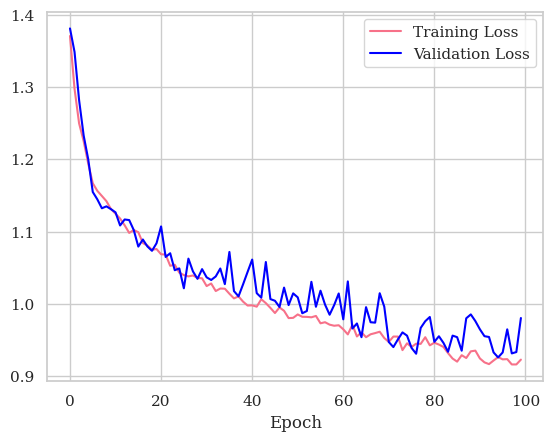

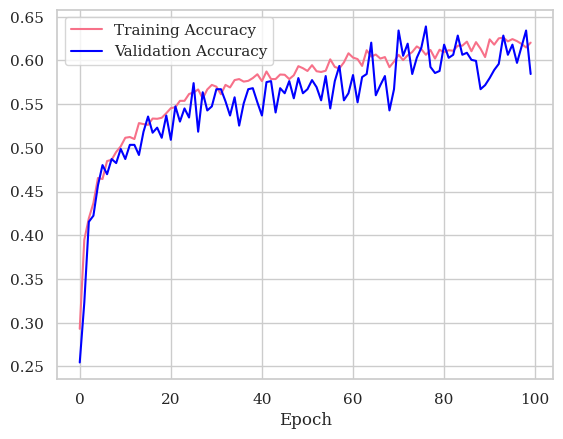

In [75]:
eegnet = build_eegnet_classifier()
eegnet, eegnet_results = CV_train(eegnet, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=100)

In [76]:
eegnet_results

{'Accuracy': [0.5844907407407407, 0.6516203703703703],
 'F1': [0.5656868363028261, 0.6439276067910379],
 'Precision': [0.6236449032847725, 0.6793830855201862],
 'Recall': [0.5844907407407407, 0.6516203703703703]}

In [104]:
test_pred = eegnet.predict(X_test_noise_2)
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 15

27/27 [==============================] - 1s 18ms/step
Accuracy:  0.6157407407407407
F1:  0.6131609384190305
Precision:  0.6396812167864149
Recall:  0.6157407407407407


In [105]:
test_pred = eegnet.predict(X_test_noise)
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 8

27/27 [==============================] - 1s 18ms/step
Accuracy:  0.5254629629629629
F1:  0.48767349456385695
Precision:  0.5851267475488261
Recall:  0.5254629629629629


In [78]:
eegnet.save('models/eegnet.h5')

In [103]:
eegnet = keras.models.load_model('models/eegnet.h5')

In [107]:
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 


In [155]:
def build_shallow_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                        input_shape=(Chans, Samples, 1),
                        kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    return Model(inputs=input_main, outputs=softmax)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
108/108 [==============================] - 17s 151ms/step - loss: 1.5054 - accuracy: 0.3212 - val_loss: 1.4052 - val_accuracy: 0.3507
Epoch 2/100
108/108 [==============================] - 15s 143ms/step - loss: 1.3566 - accuracy: 0.3929 - val_loss: 1.3273 - val_accuracy: 0.4086
Epoch 3/100
108/108 [==============================] - 14s 134ms/step - loss: 1.2828 - accuracy: 0.4366 - val_loss: 1.4827 - val_accuracy: 0.3495
Epoch 4/100
108/108 [==============================] - 15s 138ms/step - loss: 1.2435 - accuracy: 0.4523 - val_loss: 1.2639 - val_accuracy: 0.4236
Epoch 5/100
108/108 [==============================] - 15s 141ms/step - loss: 1.2103 - accuracy: 0.4777 - val_loss: 1.2438 - val_accuracy: 0.4456
Epoch 6/100
108/108 [==============================] - 15s 143ms/step - loss: 1.1869 - accuracy: 0.4789 - val_loss: 1.3020 - val_accuracy: 0.4479
Epoch 7/100
108/108 [==============================] - 15s 138ms/step - loss: 1.1520 - accuracy: 0.5012 - val_loss: 1.2496 -

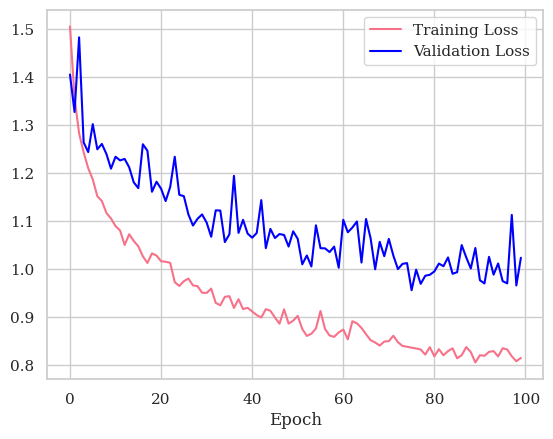

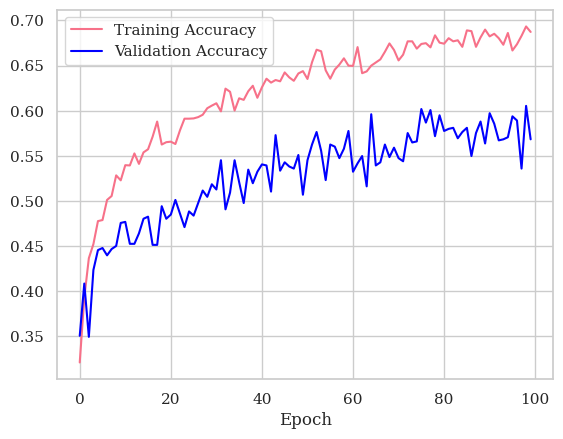

In [156]:
scn = build_shallow_conv_net()
scn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
scn, scn_results = CV_train(scn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=100)

In [157]:
scn_results

{'Accuracy': [0.5682870370370371, 0.6145833333333334],
 'F1': [0.5645457612614778, 0.616098089154518],
 'Precision': [0.5814075294623892, 0.6290582541203776],
 'Recall': [0.5682870370370371, 0.6145833333333334]}

In [158]:
test_pred = scn.predict(np.expand_dims(X_test_noise_2,-1))
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 15

27/27 [==============================] - 1s 31ms/step
Accuracy:  0.5636574074074074
F1:  0.5622026586567475
Precision:  0.6264537979386517
Recall:  0.5636574074074074


In [159]:
test_pred = scn.predict(np.expand_dims(X_test_noise,-1))
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 8

27/27 [==============================] - 1s 33ms/step
Accuracy:  0.42592592592592593
F1:  0.38483418947818854
Precision:  0.6550406880383184
Recall:  0.42592592592592593


In [160]:
scn.save('models/scn.h5')

In [161]:
scn = keras.models.load_model('models/scn.h5', custom_objects={'square':square, 'log':log})

In [162]:
def build_deep_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

Epoch 1/100


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


108/108 [==============================] - 16s 135ms/step - loss: 1.7101 - accuracy: 0.2674 - val_loss: 1.4290 - val_accuracy: 0.2674
Epoch 2/100
108/108 [==============================] - 14s 132ms/step - loss: 1.6226 - accuracy: 0.3128 - val_loss: 1.6824 - val_accuracy: 0.2581
Epoch 3/100
108/108 [==============================] - 14s 130ms/step - loss: 1.6078 - accuracy: 0.3229 - val_loss: 2.0796 - val_accuracy: 0.2593
Epoch 4/100
108/108 [==============================] - 14s 132ms/step - loss: 1.5285 - accuracy: 0.3264 - val_loss: 2.3370 - val_accuracy: 0.2477
Epoch 5/100
108/108 [==============================] - 14s 130ms/step - loss: 1.4526 - accuracy: 0.3469 - val_loss: 1.8725 - val_accuracy: 0.2639
Epoch 6/100
108/108 [==============================] - 14s 131ms/step - loss: 1.4221 - accuracy: 0.3657 - val_loss: 2.1352 - val_accuracy: 0.2569
Epoch 7/100
108/108 [==============================] - 14s 130ms/step - loss: 1.3766 - accuracy: 0.3799 - val_loss: 1.5885 - val_accurac

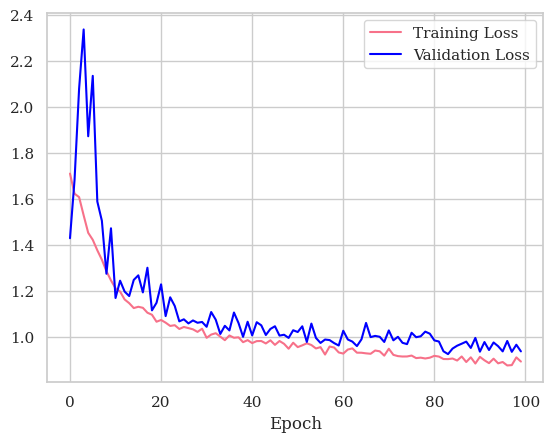

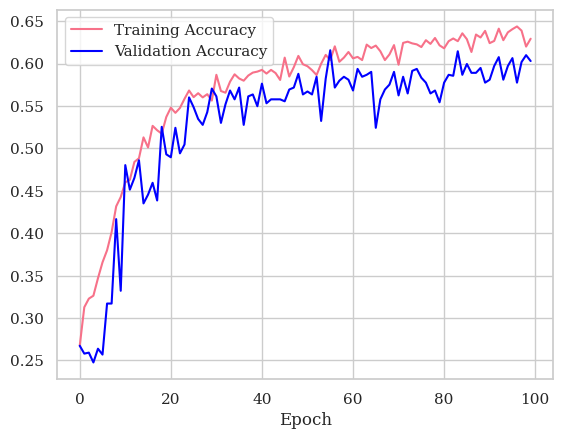

In [163]:
dcn = build_deep_conv_net()
dcn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dcn, dcn_results = CV_train(dcn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=100)

In [164]:
dcn_results

{'Accuracy': [0.6030092592592593, 0.6099537037037037],
 'F1': [0.5917885140072242, 0.5893488503579134],
 'Precision': [0.6067420271467648, 0.6183133726738377],
 'Recall': [0.6030092592592593, 0.6099537037037037]}

In [165]:
test_pred = dcn.predict(np.expand_dims(X_test_noise_2,-1))
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 15

27/27 [==============================] - 1s 36ms/step
Accuracy:  0.5891203703703703
F1:  0.5777006594328525
Precision:  0.6003727520351626
Recall:  0.5891203703703703


In [166]:
test_pred = dcn.predict(np.expand_dims(X_test_noise,-1))
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 8

27/27 [==============================] - 1s 38ms/step
Accuracy:  0.5590277777777778
F1:  0.547928522428475
Precision:  0.5876595148909717
Recall:  0.5590277777777778


In [167]:
dcn.save('models/dcn.h5')

In [168]:
dcn = keras.models.load_model('models/dcn.h5')

In [169]:
n_epochs=100
from skorch.callbacks import LRScheduler
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),]
eegv4 = NeuralNetClassifier(module=EEGNetv4,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__kernel_length=32,
        module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )

eegv4.fit(X_train, y_train, epochs=n_epochs)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4238  0.0010  1.4473
      2        1.3921  0.0010  1.2318
      3        1.3509  0.0010  1.2212
      4        1.3175  0.0010  1.2251
      5        1.2828  0.0010  1.2317
      6        1.2501  0.0010  1.2533
      7        1.2236  0.0010  1.2607
      8        1.1957  0.0010  1.2407
      9        1.1639  0.0010  1.2700
     10        1.1473  0.0010  1.2460
     11        1.1201  0.0010  1.2973
     12        1.1079  0.0010  1.2326
     13        1.1030  0.0010  1.2522
     14        1.0892  0.0010  1.2126
     15        1.0689  0.0010  1.2686
     16        1.0573  0.0009  1.2163
     17        1.0534  0.0009  1.2615
     18        1.0590  0.0009  1.2138
     19        1.0514  0.0009  1.2451
     20        1.0408  0.0009  1.2244
     21        1.0241  0.0009  1.2171
     22        1.0246  0.0009  1.2575
     23        1.0162  0.0009  1.2118
     24        1.0284  0.0009  1.2261
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv4 (EEGNetv4)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 22, 1125]          [1, 8, 22, 1126]          256                       [1, 32]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 22, 1126]          [1, 8, 22, 11

In [170]:
test_metrics(eegv4)

Accuracy:  0.6111111111111112
Precision:  0.6204360669014101
Recall:  0.6111111111111112
F1:  0.5962183215624915


In [171]:
test_metrics(eegv4, X_test = X_test_noise_2.astype(np.float32))

Accuracy:  0.6134259259259259
Precision:  0.6202784544889808
Recall:  0.6134259259259259
F1:  0.6052822220112396


In [172]:
test_metrics(eegv4, X_test = X_test_noise.astype(np.float32))

Accuracy:  0.5844907407407407
Precision:  0.5859928492849286
Recall:  0.5844907407407407
F1:  0.5825012632610672


Train Accuracy:  0.6819444444444445
Test Accuracy:  0.6111111111111112


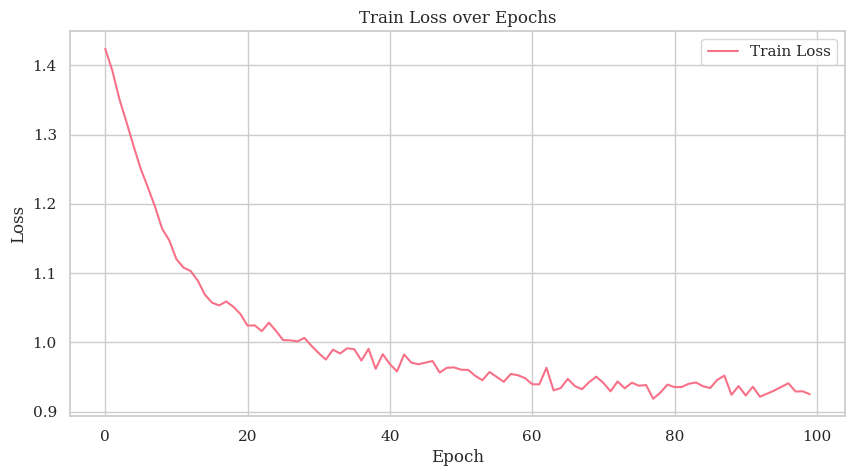

In [173]:
print("Train Accuracy: ", eegv4.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", eegv4.score(X_test, np.argmax(y_test, axis=1)))

train_loss = eegv4.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
from braindecode.models import *

In [175]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
atcnet = NeuralNetClassifier(module=ATCNet,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__add_log_softmax=False,
        # module__kernel_length=32,
        # module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
atcnet.fit(X_train, y_train, epochs=100)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4145  0.0010  7.0538
      2        1.3456  0.0010  7.0935
      3        1.2700  0.0010  7.1114
      4        1.2345  0.0010  7.0463
      5        1.1736  0.0010  7.0299
      6        1.1402  0.0010  7.1254
      7        1.0958  0.0010  7.1648
      8        1.0734  0.0010  7.0884
      9        1.0681  0.0010  7.0785
     10        1.0370  0.0010  7.1575
     11        1.0165  0.0010  7.1066
     12        0.9984  0.0010  7.0782
     13        0.9840  0.0010  7.1206
     14        0.9735  0.0010  7.0236
     15        0.9582  0.0010  7.1447
     16        0.9349  0.0009  7.1304
     17        0.9091  0.0009  7.0682
     18        0.9055  0.0009  7.0207
     19        0.9028  0.0009  7.1257
     20        0.8778  0.0009  7.0718
     21        0.8475  0.0009  7.1213
     22        0.8356  0.0009  7.0685
     23        0.8205  0.0009  7.0566
     24        0.8073  0.0009  7.1053
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_============================================================================================================================================================
  Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Kernel Shape
  ATCNet (ATCNet)                                         [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                            [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                           [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─_ConvBlock (conv_block): 1-3                          [1, 1, 1125, 22]          [1, 32, 20, 1]            --                        --
  │    └─Conv2d (conv1): 2-1                              [1, 1, 11

Train Accuracy:  0.9675925925925926
Test Accuracy:  0.6782407407407407


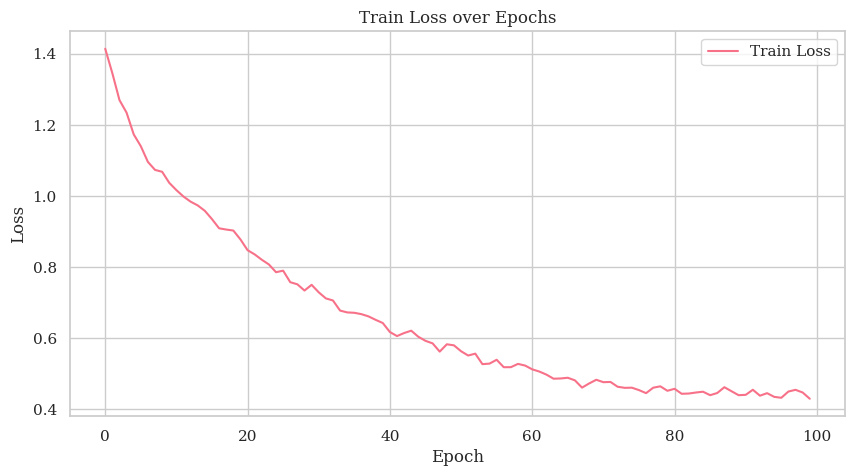

In [176]:
print("Train Accuracy: ", atcnet.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", atcnet.score(X_test, np.argmax(y_test, axis=1)))

train_loss = atcnet.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
test_metrics(atcnet)

Accuracy:  0.6782407407407407
Precision:  0.6761456177768669
Recall:  0.6782407407407407
F1:  0.675102053398779


In [178]:
test_metrics(atcnet, X_test_noise_2.astype(np.float32))

Accuracy:  0.6064814814814815
Precision:  0.6268399428621246
Recall:  0.6064814814814815
F1:  0.6064272690490587


In [179]:
test_metrics(atcnet, X_test_noise.astype(np.float32))

Accuracy:  0.4756944444444444
Precision:  0.5618267107067596
Recall:  0.4756944444444444
F1:  0.45737597974278305


In [180]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
conformer = NeuralNetClassifier(module=EEGConformer,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__final_fc_length='auto',
        module__add_log_softmax=False,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__betas=(0.5, 0.999),
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
conformer.fit(X_train, y_train, epochs=100)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4349  0.0010  7.9347
      2        1.4108  0.0010  7.7551
      3        1.3486  0.0010  7.8107
      4        1.3105  0.0010  7.8479
      5        1.2934  0.0010  7.8550
      6        1.2790  0.0010  7.8690
      7        1.2743  0.0010  7.8430
      8        1.2608  0.0010  8.0712
      9        1.2572  0.0010  8.1846
     10        1.2454  0.0010  8.2785
     11        1.2198  0.0010  8.2650
     12        1.1846  0.0010  8.4254
     13        1.1633  0.0010  8.3885
     14        1.1491  0.0010  8.5006
     15        1.1497  0.0010  8.3075
     16        1.1322  0.0009  8.4448
     17        1.1252  0.0009  8.5344
     18        1.1233  0.0009  8.4784
     19        1.1008  0.0009  8.4264
     20        1.0984  0.0009  8.5576
     21        1.0730  0.0009  8.7189
     22        1.0775  0.0009  8.5387
     23        1.0645  0.0009  8.5170
     24        1.0554  0.0009  8.4567
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  EEGConformer (EEGConformer)                                  [1, 22, 1125]             [1, 4]                    --                        --
  ├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 22, 1125]          [1, 69, 40]               --                        --
  │    └─Sequential (shallownet): 2-1                          [1, 1, 22, 1125]          [1, 40, 1, 69]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 1, 22, 1125]          [1, 40, 22, 1101]         1,040                     [1, 25]
  │    │    └─Conv2d (1): 3-2   

Train Accuracy:  0.9877314814814815
Test Accuracy:  0.5555555555555556


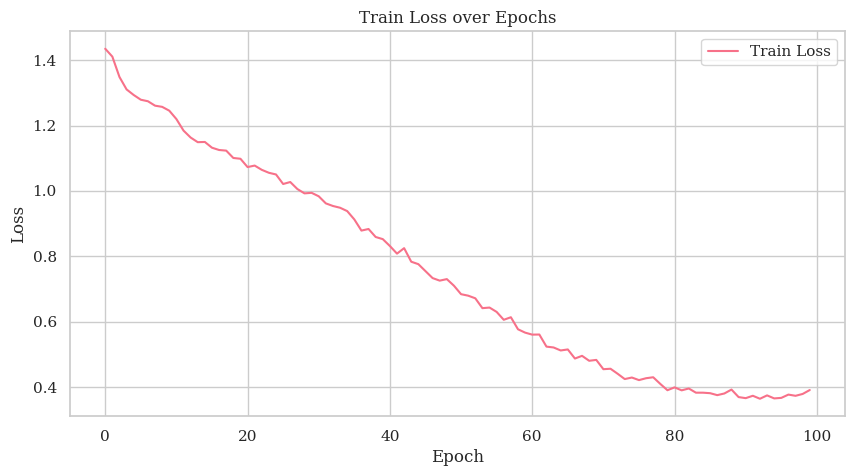

In [181]:
print("Train Accuracy: ", conformer.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", conformer.score(X_test, np.argmax(y_test, axis=1)))

train_loss = conformer.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
test_metrics(conformer)

Accuracy:  0.5555555555555556
Precision:  0.5495339741780303
Recall:  0.5555555555555556
F1:  0.5505290512744598


In [183]:
test_metrics(conformer, X_test_noise_2.astype(np.float32))

Accuracy:  0.5428240740740741
Precision:  0.5388271078514981
Recall:  0.5428240740740741
F1:  0.5386548091871487


In [184]:
test_metrics(conformer, X_test_noise.astype(np.float32))

Accuracy:  0.5196759259259259
Precision:  0.5276989200072988
Recall:  0.5196759259259259
F1:  0.5143187553523078


In [185]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans and time steps from dataset
n_chans = 22
input_window_samples = 1125

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()
    

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [186]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

shallowfbcsp = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
shallowfbcsp.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.4125        1.5709  0.0006  0.9509
      2            0.4889        1.4146  0.0006  0.6160
      3            0.5046        1.3190  0.0006  0.6138
      4            0.5394        1.2567  0.0006  0.6504
      5            0.5525        1.2079  0.0006  0.6111
      6            0.5884        1.1629  0.0006  0.6089
      7            0.5845        1.1288  0.0006  0.6136
      8            0.6130        1.1047  0.0006  0.6106
      9            0.5921        1.0710  0.0006  0.6238
     10            0.6451        1.0398  0.0006  0.6019
     11            0.6350        1.0008  0.0006  0.6032
     12            0.6694        1.0019  0.0006  0.6112
     13            0.6725        0.9744  0.0006  0.6315
     14            0.6998        0.9735  0.0006  0.6155
     15            0.6998        0.9491  0.0006  0.6252
     16            0.6521        0.9181  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

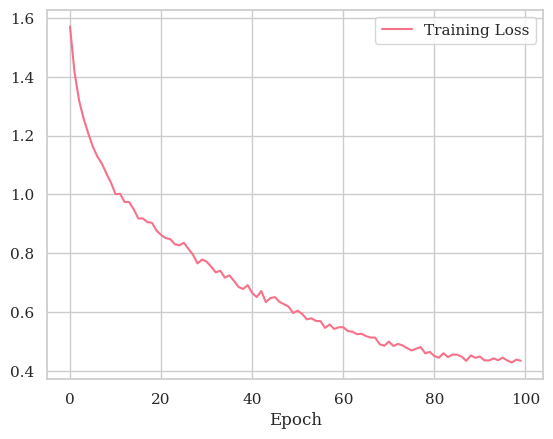

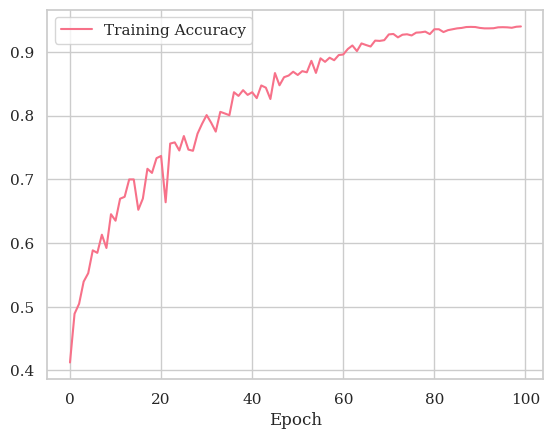

In [187]:
loss = []
acc = []
for a in shallowfbcsp.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [188]:
shallowfbcsp.score(X_test, np.argmax(y_test, axis=1))

0.6157407407407407

In [189]:
test_metrics(shallowfbcsp)

Accuracy:  0.6157407407407407
Precision:  0.615826298698625
Recall:  0.6157407407407407
F1:  0.614569952259947


In [190]:
test_metrics(shallowfbcsp, X_test_noise_2)

Accuracy:  0.6122685185185185
Precision:  0.6123444779402782
Recall:  0.6122685185185185
F1:  0.6115601756460647


In [191]:
test_metrics(shallowfbcsp, X_test_noise)

Accuracy:  0.5625
Precision:  0.5716742050421234
Recall:  0.5625
F1:  0.5581084398860547


In [192]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

eegnetv4 = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
eegnetv4.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGNetv4: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2687        1.4050  0.0006  1.5139
      2            0.2694        1.3536  0.0006  1.2083
      3            0.2912        1.3081  0.0006  1.2255
      4            0.3671        1.2585  0.0006  1.2812
      5            0.4361        1.2332  0.0006  1.2283
      6            0.4921        1.2005  0.0006  1.2098
      7            0.5169        1.1674  0.0006  1.2658
      8            0.5257        1.1352  0.0006  1.2444
      9            0.5588        1.1018  0.0006  1.2702
     10            0.5928        1.0856  0.0006  1.1986
     11            0.5947        1.0633  0.0006  1.2760
     12            0.6007        1.0450  0.0006  1.2540
     13            0.5986        1.0403  0.0006  1.2641
     14            0.6148        1.0308  0.0006  1.2889
     15            0.6211        1.0160  0.0006  1.1891
     16            0.6322        1.0085  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv4 (EEGNetv4)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 22, 1125]          [1, 8, 22, 1126]          512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 22, 1126]          [1, 8, 22, 112

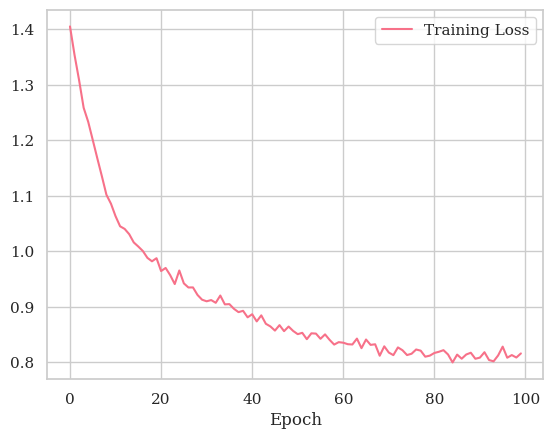

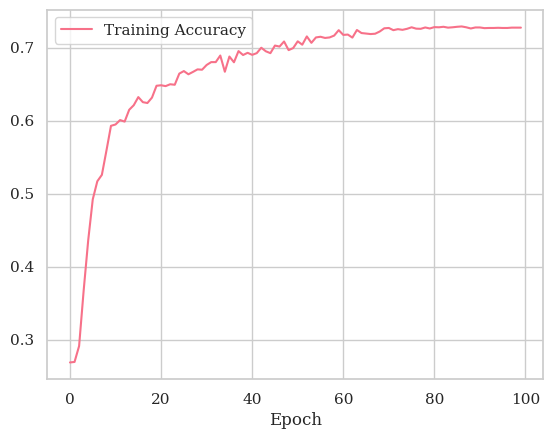

In [193]:
loss = []
acc = []
for a in eegnetv4.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [194]:
eegnetv4.score(X_test, np.argmax(y_test, axis=1))

0.6550925925925926

In [195]:
test_metrics(eegnetv4)

Accuracy:  0.6550925925925926
Precision:  0.6593455398017879
Recall:  0.6550925925925926
F1:  0.651212569506572


In [196]:
test_metrics(eegnetv4, X_test_noise_2)

Accuracy:  0.6111111111111112
Precision:  0.6184006755938525
Recall:  0.6111111111111112
F1:  0.6095044823635744


In [197]:
test_metrics(eegnetv4, X_test_noise)

Accuracy:  0.5451388888888888
Precision:  0.6044933875272197
Recall:  0.5451388888888888
F1:  0.5323735122946127


In [198]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGNetv1(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

eegnetv1 = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
eegnetv1.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGNetv1: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2606        1.7212  0.0006  3.0732
      2            0.2817        1.5846  0.0006  2.2800
      3            0.2863        1.4999  0.0006  2.3170
      4            0.3426        1.4416  0.0006  2.3039
      5            0.3574        1.4088  0.0006  2.2954
      6            0.3194        1.3825  0.0006  2.3242
      7            0.4016        1.3554  0.0006  2.2978
      8            0.3623        1.3377  0.0006  2.2963
      9            0.3771        1.3361  0.0006  2.2369
     10            0.3905        1.3132  0.0006  2.2532
     11            0.4315        1.2991  0.0006  2.2642
     12            0.4243        1.2692  0.0006  2.2431
     13            0.4424        1.2631  0.0006  2.2527
     14            0.4618        1.2431  0.0006  2.2727
     15            0.4671        1.2362  0.0006  2.2722
     16            0.4773        1.2091  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv1 (EEGNetv1)                      [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Conv2d (conv_1): 1-2                   [1, 22, 1125, 1]          [1, 16, 1125, 1]          368                       [1, 1]
  ├─BatchNorm2d (bnorm_1): 1-3             [1, 16, 1125, 1]          [1, 16, 1125, 1]          32                        --
  ├─Expression (elu_1): 1-4                [1, 16, 1125, 1]          [1, 16, 1125, 1]          --                        --
  ├─Expression (permute_1): 1-

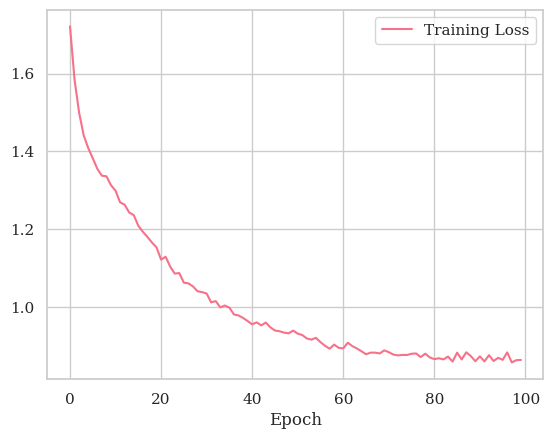

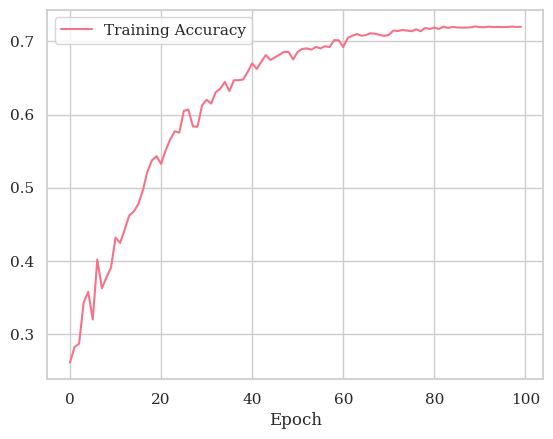

In [199]:
loss = []
acc = []
for a in eegnetv1.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [200]:
eegnetv1.score(X_test, np.argmax(y_test, axis=1))

0.6064814814814815

In [201]:
test_metrics(eegnetv1)


Accuracy:  0.6064814814814815
Precision:  0.6085909406668846
Recall:  0.6064814814814815
F1:  0.6025199394606228


In [202]:
test_metrics(eegnetv1, X_test_noise_2)

Accuracy:  0.5740740740740741
Precision:  0.5924251153456682
Recall:  0.5740740740740741
F1:  0.5723176878450332


In [203]:
test_metrics(eegnetv1, X_test_noise)

Accuracy:  0.4930555555555556
Precision:  0.6200784257514947
Recall:  0.4930555555555556
F1:  0.4530858065783133


In [204]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

deep4net = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
deep4net.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2650        1.7174  0.0006  0.9592
      2            0.2505        1.6652  0.0006  0.6609
      3            0.2713        1.6182  0.0006  0.6745
      4            0.2868        1.5573  0.0006  0.6549
      5            0.2687        1.5443  0.0006  0.6713
      6            0.3178        1.5084  0.0006  0.6512
      7            0.2792        1.4475  0.0006  0.6570
      8            0.3012        1.4123  0.0006  0.6644
      9            0.3583        1.3756  0.0006  0.6658
     10            0.3743        1.3455  0.0006  0.6659
     11            0.4058        1.3377  0.0006  0.6626
     12            0.3725        1.2936  0.0006  0.6637
     13            0.3991        1.2681  0.0006  0.6573
     14            0.3868        1.2541  0.0006  0.6596
     15            0.4188        1.2221  0.0006  0.6488
     16            0.3979        1.2053  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  Deep4Net (Deep4Net)                      [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 25, 1116, 1]          14,025                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 25, 1116, 1]          [1, 25, 1116, 1]          50                        --
  ├─Expression (conv_nonlin): 1-5 

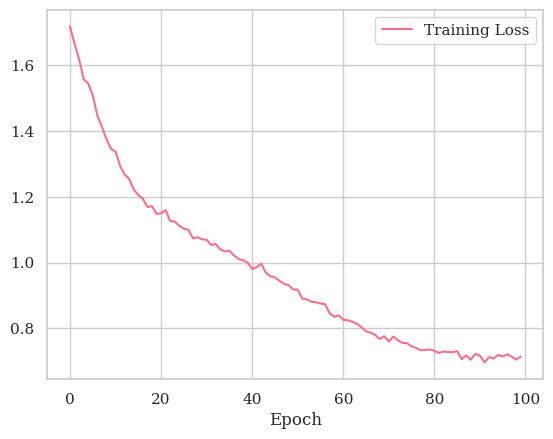

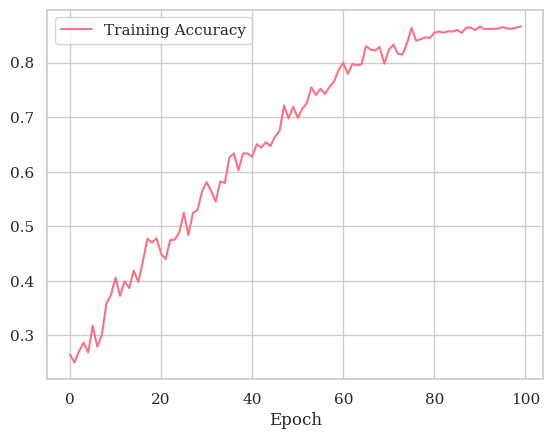

In [205]:
loss = []
acc = []
for a in deep4net.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [206]:
deep4net.score(X_test, np.argmax(y_test, axis=1))

0.5763888888888888

In [207]:
test_metrics(deep4net)

Accuracy:  0.5763888888888888
Precision:  0.5855629495474242
Recall:  0.5763888888888888
F1:  0.5660136577528296


In [208]:
test_metrics(deep4net, X_test_noise_2)

Accuracy:  0.6076388888888888
Precision:  0.6071049253034547
Recall:  0.6076388888888888
F1:  0.603934666393548


In [209]:
test_metrics(deep4net, X_test_noise)

Accuracy:  0.5787037037037037
Precision:  0.5768911500727294
Recall:  0.5787037037037037
F1:  0.5769432445330951


In [210]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGITNet(

    n_classes,
        n_chans,
    input_window_samples=input_window_samples,
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

eegitnet = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
eegitnet.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGITNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2995        1.4164  0.0006  2.7340
      2            0.3282        1.3746  0.0006  2.1087
      3            0.3218        1.3509  0.0006  2.0996
      4            0.3544        1.3182  0.0006  2.1056
      5            0.3711        1.2952  0.0006  2.0979
      6            0.3956        1.2716  0.0006  2.0850
      7            0.4722        1.2479  0.0006  2.1786
      8            0.5227        1.2188  0.0006  2.1250
      9            0.5400        1.1938  0.0006  2.1191
     10            0.5444        1.1563  0.0006  2.1463
     11            0.5525        1.1461  0.0006  2.1135
     12            0.5623        1.0990  0.0006  2.1247
     13            0.5734        1.0847  0.0006  2.1157
     14            0.5817        1.0671  0.0006  2.1167
     15            0.5991        1.0520  0.0006  2.1256
     16            0.6139        1.0568  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGITNet (EEGITNet)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Sequential (input_preprocess): 1-1               [1, 22, 1125]             [1, 1, 22, 1125]          --                        --
  │    └─Ensure4d (0): 2-1                           [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  │    └─Rearrange (1): 2-2                          [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─_InceptionBlock (inception_block): 1-2           [1, 1, 22, 1125]          [1, 14, 1, 1125]   

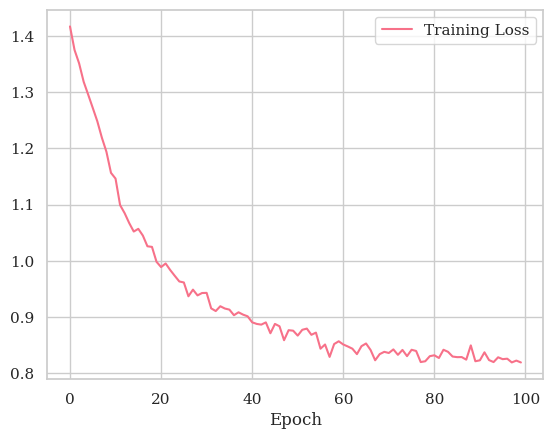

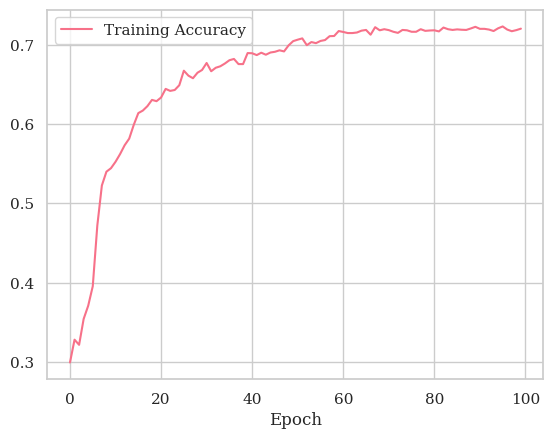

In [211]:
loss = []
acc = []
for a in eegitnet.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [212]:
eegitnet.score(X_test, np.argmax(y_test, axis=1))

0.5833333333333334

In [213]:
test_metrics(eegitnet)

Accuracy:  0.5833333333333334
Precision:  0.5894214878518316
Recall:  0.5833333333333334
F1:  0.5669154421463426


In [214]:
test_metrics(eegitnet, X_test_noise_2)

Accuracy:  0.5682870370370371
Precision:  0.5729636863560817
Recall:  0.5682870370370371
F1:  0.5537474669749768


In [215]:
test_metrics(eegitnet, X_test_noise)

Accuracy:  0.5428240740740741
Precision:  0.5457303427932052
Recall:  0.5428240740740741
F1:  0.5381679275541168


In [40]:
from EEGModels import *

In [41]:
X_train.shape

(4320, 22, 1125)

In [48]:
fusion = EEGNet_fusion(nb_classes=4, Chans=22, Samples=1125,
                  dropoutRate=0.5, norm_rate=0.25, dropoutType='Dropout', cpu=True)
fusion.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
fusion, fusion_results = CV_train(fusion, torch.tensor([X_train, X_train, X_train]), X_test, n_epochs=1)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1478062080000 bytes.

In [49]:
temp = X_train

In [51]:
X_train = X_train.transpose(0,2,1)

In [52]:
X_train.shape

(4320, 1125, 22)

In [53]:
fusion = EEGNet_fusion_V2(nb_classes=4, Chans=22, Samples=1125,
                  dropoutRate=0.5, norm_rate=0.25, dropoutType='Dropout', cpu=True)
fusion.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
fusion, fusion_results = CV_train(fusion, torch.tensor([X_train, X_train, X_train, X_train, X_train]), X_test, n_epochs=1)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1478062080000 bytes.

In [ ]:
dcn_results

{'Accuracy': [0.6030092592592593, 0.6099537037037037],
 'F1': [0.5917885140072242, 0.5893488503579134],
 'Precision': [0.6067420271467648, 0.6183133726738377],
 'Recall': [0.6030092592592593, 0.6099537037037037]}

In [ ]:
test_pred = dcn.predict(np.expand_dims(X_test_noise_2,-1))
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 15

27/27 [==============================] - 1s 36ms/step
Accuracy:  0.5891203703703703
F1:  0.5777006594328525
Precision:  0.6003727520351626
Recall:  0.5891203703703703


In [ ]:
test_pred = dcn.predict(np.expand_dims(X_test_noise,-1))
pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
print("Accuracy: ",accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
print("F1: ",f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
print("Precision: ",precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
print("Recall: ",recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
## SNR 8

27/27 [==============================] - 1s 38ms/step
Accuracy:  0.5590277777777778
F1:  0.547928522428475
Precision:  0.5876595148909717
Recall:  0.5590277777777778


In [ ]:
dcn.save('models/dcn.h5')

In [ ]:
dcn = keras.models.load_model('models/dcn.h5')